# Previsão de valores para vários valores, incluindo Brasil

## Data preparation 

In [1]:
import pandas as pd
datatemplate = '../Tables/ML/time_series_covid19_{}.csv'

fields = ['confirmed_global', 'deaths_global', 'recovered_global']
dfs = dict()
for field in fields: 
    dfs[field] = pd.read_csv(datatemplate.format(field))
    
# loop on the dataframe dictionary
for field, df in dfs.items():
    # group by country, to sum on states
    df = df.groupby('Country/Region', as_index=False).sum()
    # turn each measurement column into a separate line, 
    # and store the results in a new dataframe
    df = df.melt(id_vars=['Country/Region', 'Lat', 'Long'],
                 value_name='counts')
    # keep track of the quantity that is measured 
    # either Confirmed, Deaths, or Recovered
    df['quantity'] = field
    # change column names 
    df.columns =  ['country', 'lat', 'lon', 'date', 'counts', 'quantity']
    # replace the dataframe in the dictionary
    dfs[field] = df

    
dfall = pd.concat(dfs.values())
dfall['date'] = pd.to_datetime(dfall['date'])
print(dfall)

                  country        lat        lon       date  counts  \
0             Afghanistan  33.000000  65.000000 2020-01-22       0   
1                 Albania  41.153300  20.168300 2020-01-22       0   
2                 Algeria  28.033900   1.659600 2020-01-22       0   
3                 Andorra  42.506300   1.521800 2020-01-22       0   
4                  Angola -11.202700  17.873900 2020-01-22       0   
...                   ...        ...        ...        ...     ...   
24059  West Bank and Gaza  31.952200  35.233200 2020-05-28     368   
24060      Western Sahara  24.215500 -12.885800 2020-05-28       6   
24061               Yemen  15.552727  48.516388 2020-05-28      11   
24062              Zambia -15.416700  28.283300 2020-05-28     779   
24063            Zimbabwe -20.000000  30.000000 2020-05-28      28   

               quantity  
0      confirmed_global  
1      confirmed_global  
2      confirmed_global  
3      confirmed_global  
4      confirmed_global  
...

## A Naive Fit
#### Vamos fazer um ajuste ingênuo do número de casos confirmados para a França em função do número de dias

In [2]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# exponential function for the fit
expo = lambda x, a, b : np.exp( a*(x-b) )

In [3]:
# select confirmed cases for Brazil
sel = dfall[(dfall['country']=='Brazil') &
            (dfall['quantity']=='confirmed_global')]

# y is the number of counts
yp = sel['counts']


# create x from 0 to number of points in yp
xp = np.arange(len(yp))

# fit the curve to get the parameters
pars, cov = curve_fit(expo, xp, yp) 

In [4]:
# fit the curve to get the parameters
pars, cov = curve_fit(expo, xp, yp) 

### Traçar os pontos e o exponencial ajustado. Observe que o exponencial é plotado no mesmo intervalo x, mas com maior granularidade para uma curva mais suave.

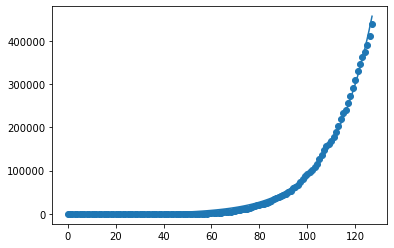

In [5]:
plt.scatter(xp, yp)
linx = np.linspace(0, xp.max(), 101)
f = expo(linx, *pars)
plt.plot(linx, f)

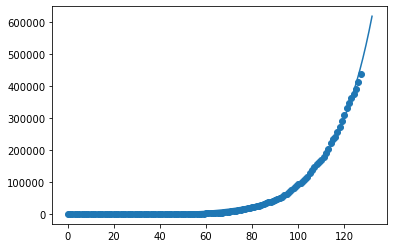

In [6]:
plt.scatter(xp, yp)
# extrapolate by 5 days:
linx = np.linspace(0, xp.max()+5, 101)
f = expo(linx, *pars)
plt.plot(linx, f)

In [7]:
print('expected number of cases at day {} : {}'.format(
    int(linx[-1]), int(f[-1])
))

expected number of cases at day 132 : 617044


<ErrorbarContainer object of 3 artists>

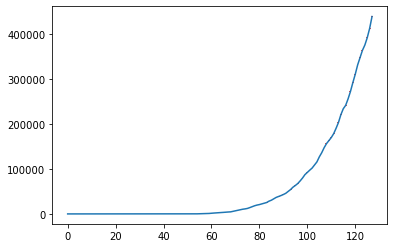

In [8]:
dn = np.sqrt(yp)
plt.errorbar(xp, yp, yerr=dn, ecolor='red')

# Statistical uncertainty 
### Red color

(0.1, 3000)

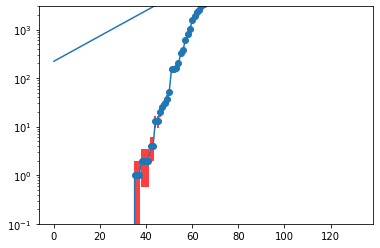

In [9]:
plt.errorbar(xp, yp, yerr=dn, ecolor='red', marker='o')
plt.plot(linx, f)
plt.yscale('log')
plt.ylim(0.1, 3000)

## A documentação de scipy.optimize.curve_fit nos diz que, se as incertezas não forem fornecidas como argumento sigma, todas as incertezas serão definidas como 1! isso claramente não é o que queremos, então refazemos o ajuste com as incertezas adequadas

In [10]:
pars, cov = curve_fit(expo, xp, yp, sigma=dn) 

C:\OSGEO4~1\apps\Python37\lib\site-packages\scipy\optimize\minpack.py:734: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
C:\OSGEO4~1\apps\Python37\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


## Defina a incerteza como 1 para esses dias, o que é mais ou menos correto no contexto desse problema

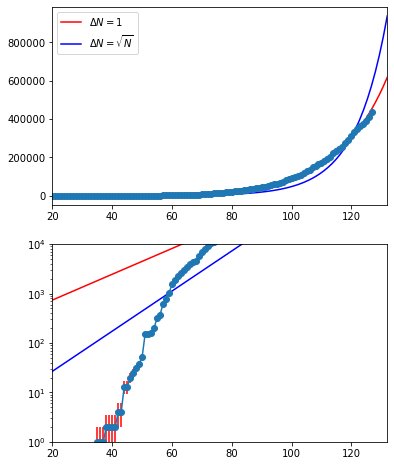

In [11]:
dn[dn==0] = 1
# with uncertainties
pars, cov = curve_fit(expo, xp, yp, sigma=dn) 
f2 = expo(linx, *pars)
plt.figure(figsize=(6,8))
# lin scale
plt.subplot(2,1,1)
plt.errorbar(xp, yp, yerr=dn, ecolor='red', marker='o')
plt.plot(linx, f, color='red', label='$\Delta N=1$')
plt.plot(linx, f2, color='blue', label='$\Delta N = \sqrt{N}$')
plt.legend()
plt.xlim(20, linx[-1])
# log scale 
plt.subplot(2,1,2)
plt.errorbar(xp, yp, yerr=dn, ecolor='red', marker='o')
plt.plot(linx, f, color='red')
plt.plot(linx, f2, color='blue')
plt.ylim(1, 10000)
plt.xlim(20, linx[-1])
plt.yscale('log')

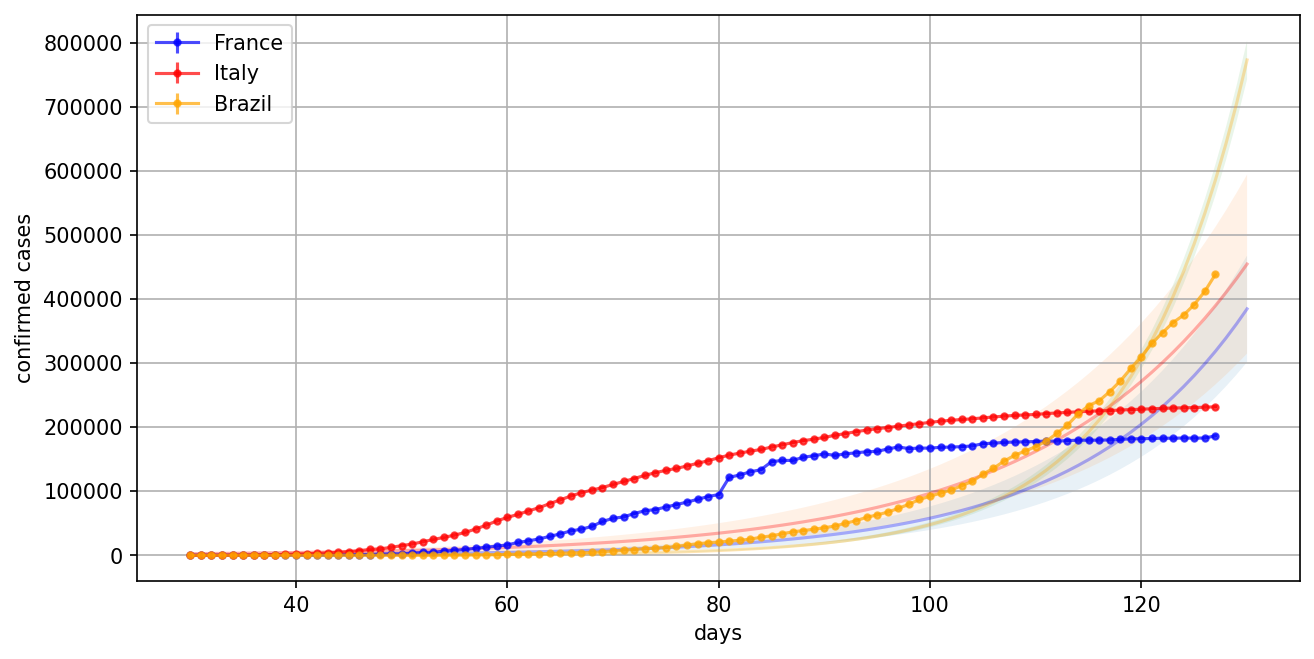

In [12]:
def sigmaf(x, f, a0, cov): 
    sigmaa2 = cov[0,0]
    sigmab2 = cov[1,1]
    sigmaab = cov[0,1] # or 1,0
    return f * np.sqrt(x**2 * sigmaa2 + a0**2 * sigmab2 - 2*x*a0*sigmaab)

def plot(countries, xrange,
         dtype='confirmed_global',
         yrange=None,
         yscale='linear'): 
    '''plot the covid-19 data with an exponential fit.
    - countries: list of countries
    - xrange: fit range, e.g. (30,55)
    - yscale: log or linear
    - yrange: well, y range, useful in log mode.
    '''
    xmin, xmax = xrange
    linx = np.linspace(xmin, xmax, 101)    
    colors = ['blue', 'red', 'orange', 'green']
    for i, country in enumerate(countries): 
        color = colors[i]
        sel = dfall[ (dfall['country']==country) &
                 (dfall['quantity']==dtype)]
        yp = sel['counts'][xmin:xmax+1]
        xp = np.arange(len(yp))+xmin
        syp = np.sqrt(yp)
        syp[syp==0]=1
        plt.errorbar(xp, yp, yerr=syp, label=country, 
                     alpha=0.7, marker='.', color=color)
        pars, cov = curve_fit(expo, xp, yp, sigma=syp)
        f = expo(linx, *pars)
        plt.plot(linx, f, 
                 color=color, alpha=0.3)
        df = sigmaf(linx, f, pars[0], cov)
        bandp = f+df
        bandm = f-df
        plt.fill_between(linx, bandm, bandp, alpha=0.1)
    plt.legend(loc='upper left')
    plt.xlabel('days')
    plt.ylabel('confirmed cases')
    plt.yscale(yscale)
    if yrange: 
        plt.ylim(*yrange)
    plt.savefig('Model1.png')
    plt.grid()


plt.figure(dpi=150, figsize=(10,5))
plot(['France', 'Italy', 'Brazil'], 
     dtype='confirmed_global',
     xrange=(30, 130))

### Verifica-se que, considerando desde o dia 30 até ao dia 130 que o modelo apresenta bastantes erros. Seria de esperar que todos os países (França, Itália e Brasil) tivessem mais casos ao fim de 130 dias do que realmente foram registados.